# TP 3 - Classification bayésienne, Arbres et Sélection de modèles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

## 1 Données du TP
Nous utiliserons deux bases de données réélles pour ce TP, les données USPS (cells du TP1) et une
base de films extraite du site IMDB. Les deux sont disponibles sur le site du cours. Pour le code, vous
pouvez utiliser la bibliotheque sklearn lorsque cela vous parait utile (e.g. matrice de confusion, AUC,
validation croisee ...).

### 1.1 Données USPS
Ces données sont des images de chiffres manuscrits, toutes de taille 16 × 16, chacune représentée par
un vecteur de taille 256 : chaque dimension représente l’intensité d’un pixel par un réel entre 0 et 1.
La fonction load_usps ci-dessous permet de charger les données à partir d’un fichier - elle renvoie la
matrice des données et le vecteur de labels (entre 0 et 9), la fonction show_usps permet de visualiser
une des images passée en paramètre.

In [2]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

### 1.2 Données IMDB
Chaque ligne du tableau data correspond à la description d’un film (le titre dans id2titles, chaque
colonne à un attribut (dont la signification est donnée par fields). La plupart sont des genres (action,
comédie, ...), la valeur 1 indique l’appartenance du film au genre (0 sinon). Les dernières colonnes
concernent l’année de production, la durée du film, le budget, le nombre de vote et la note moyenne
attribuée au film.

In [3]:
# data : tableau ( films , features ) , id2titles : dictionnaire id -> titre ,
# fields : id_feature -> nom
[ data_imdb , id2titles , fields ]= pickle.load (open("imdb_extrait.pkl","rb"))
# la derniere colonne est le vote
datax = data_imdb [: ,:32]
rating = data_imdb [: ,33]

## 2 Classifieur naïf bayésien et validation croisée
Dans cette partie, on s’intéresse au modèle du classifieur bayésien naïf et aux données USPS. Ce modèle suppose que chaque dimension de description est une variable aléatoire indépendante des autres, il s’agit ainsi d’apprendre un modèle par classe $ y_j : P(y = y_j |x) = \frac{p(x|y=y_j )P(y=y_j)}{p(x)} = \prod_i^d p(x_i | y = y_j )\frac{P(y=y_j)}{p(x)} $.

Pour une dimension continue i et un label j, on fait généralement l’hypothèse que $ x_i|y = y_j $ suit une loi normale de paramètre $(\mu_{i,j} , \sigma_{i,j} )$ qu’il faut estimer par maximum de vraisemblance. La classification se fait aussi par maximum de vraisemblance, en prédisant la classe $ argmax_{yj} P(y = y_j|x)$. On remarque que le terme $p(x)$ ne joue pas de rôle dans la classification.

#### Q 2.1 Apprentissage d’un modèle

In [4]:
def fit_bayes_label(data,labels,label):
    data_labeled = np.array([data[i,:] for i in range(len(labels)) if labels[i] == label]).reshape(-1, 256)
    means = np.mean(data_labeled, axis=0)
    variances = np.var(data_labeled, axis=0)
    return means, variances

def fit_bayes(data,labels):
    return {label: fit_bayes_label(data,labels,label) for label in set(labels)}

For classe  0  : 



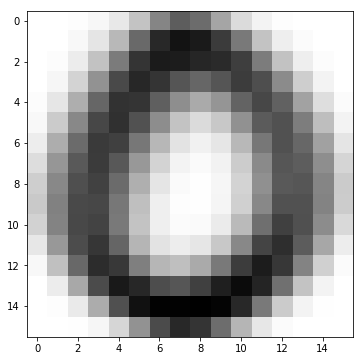

For classe  1  : 



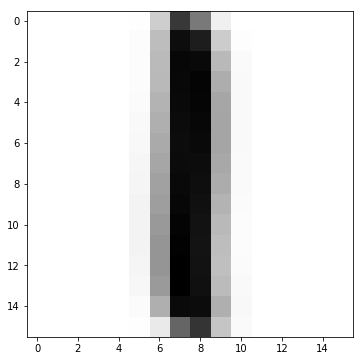

For classe  2  : 



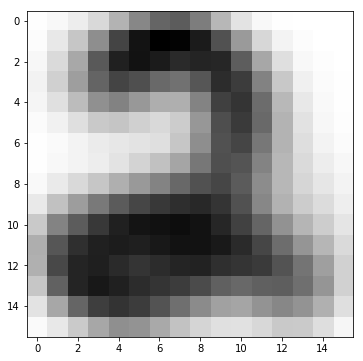

For classe  3  : 



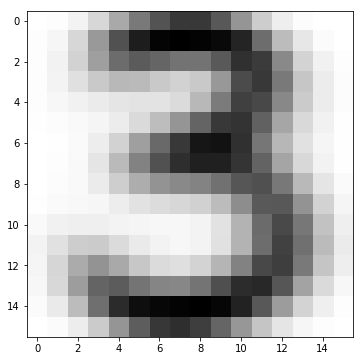

For classe  4  : 



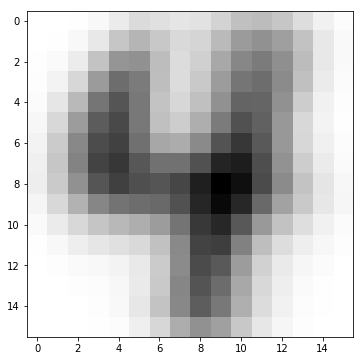

For classe  5  : 



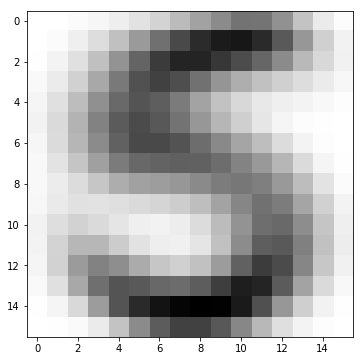

For classe  6  : 



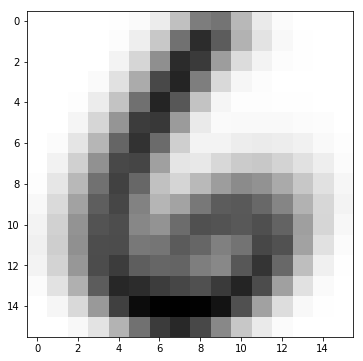

For classe  7  : 



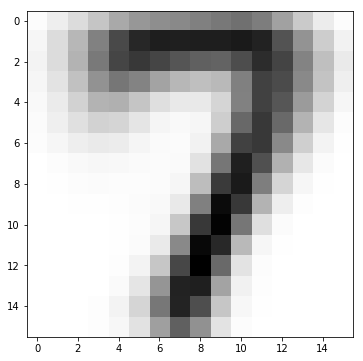

For classe  8  : 



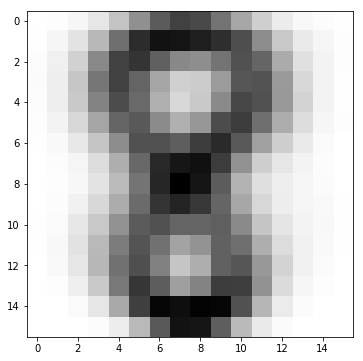

For classe  9  : 



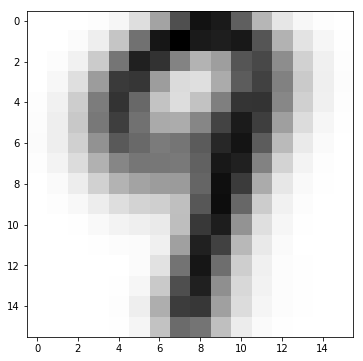

In [5]:
def question213 ():
    data_train, labels_train = load_usps('USPS_train.txt')
    dict_data = fit_bayes(data_train, labels_train)
    for label in range(10):
        means, variances = dict_data[label]
        
        print('For classe ', label, ' : \n')
        plt.figure(figsize=(20,6))
        show_usps(255-means)
        plt.show()
    return [data_train, labels_train]

data_train, labels_train = question213 ()

On peut remarque que les classes de chiffres 2,4,5,6,9 sont les plus difficiles à différencier.

#### Q 2.2 Utilisation du modèle

In [6]:
def log_vraissemblance(data,model,y):
    eps = 10**-10
    return -np.sum(np.divide(np.square(data-model[y][0]),(2*np.square(model[y][1])+eps))+np.log(model[y][1]+eps), axis=1)

Dans cette fonction on a théoriquement la division par 0 mais on peut éviter ce problème si on ajoute la petite valeur $\varepsilon > 0$.

In [7]:
def predict_bayes(data,model):
    labels = list(model.keys())
    return np.array([labels[i] for i in np.array([ log_vraissemblance(data,model,y) for y in labels]).argmax(0)])

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

plt.rcParams['figure.figsize'] = [10.0, 10.0]

In [9]:
class_names = np.arange(10)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

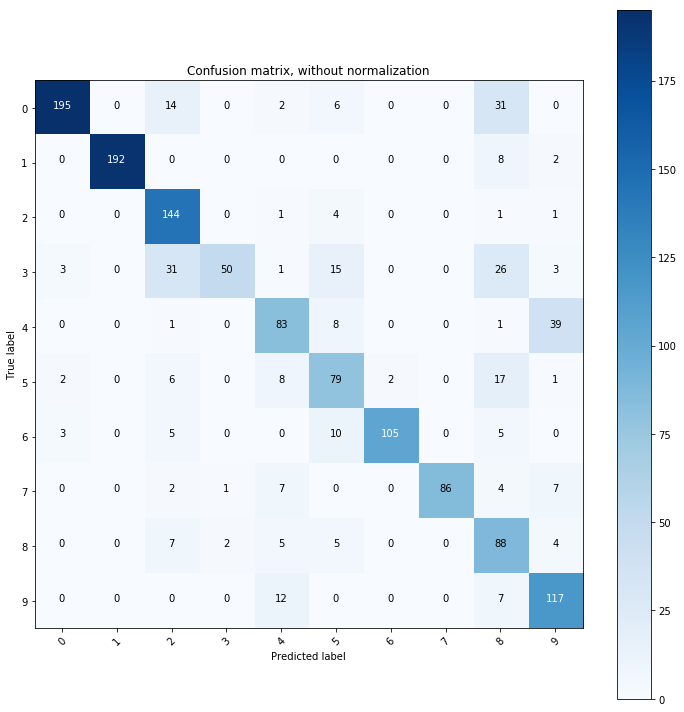

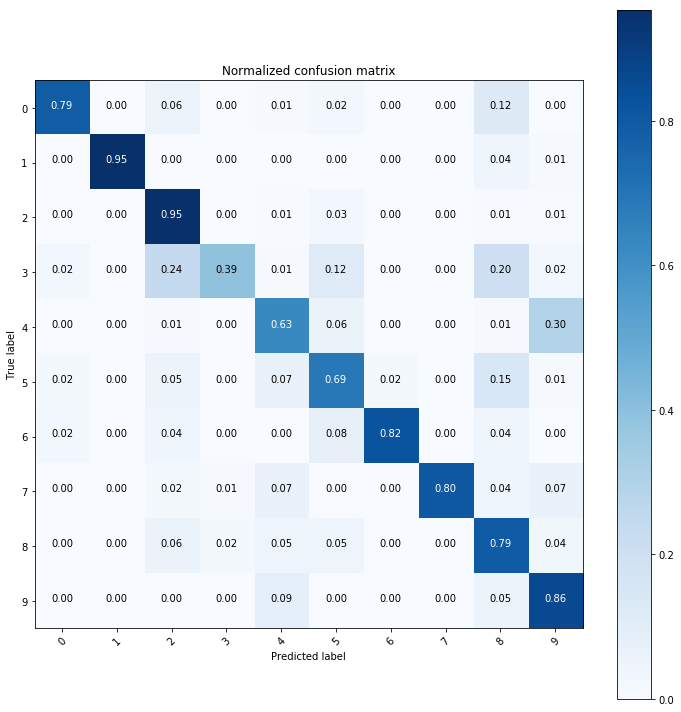

In [10]:
def question223 (data, labels, proportion = 0.2, without_normalize = False): 
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= proportion , random_state=19)
    
    model = fit_bayes(X_train, y_train)
    y_pred = predict_bayes(X_test, model)
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    
    if without_normalize : 
        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                              title='Normalized confusion matrix')
        plt.show()
        
    else :
        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title='Confusion matrix, without normalization')

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                              title='Normalized confusion matrix')
        plt.show()
    
question223(data_train, labels_train)

En regardant sur des matrices de confusion on voit que le plus forte erreur (la plus petite valeur de la matrice de confusion) est pour la classe "3" qui a parfois été prédit comme "2" ou "8".

#### Q 2.3 Comparaison des résultats


 Proportions [train, test] : [0.1, 0.9] 



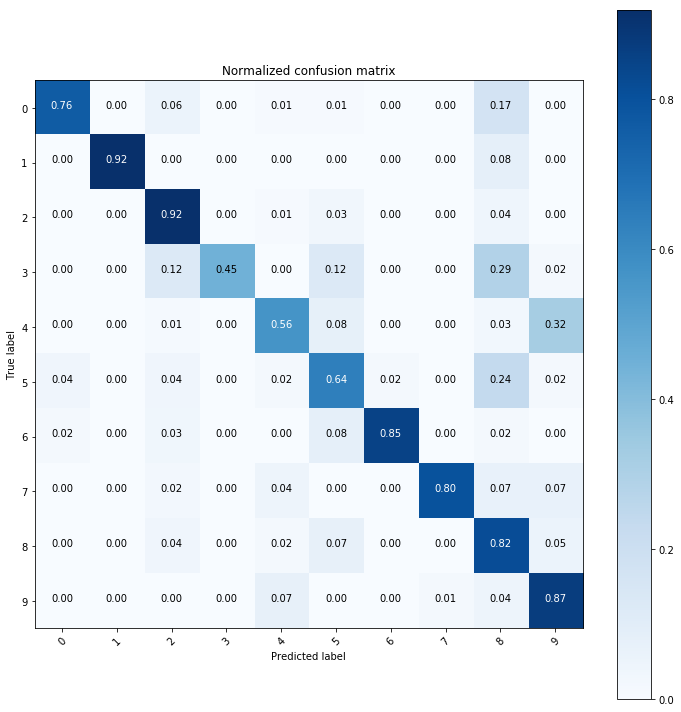


 Proportions [train, test] : [0.2, 0.8] 



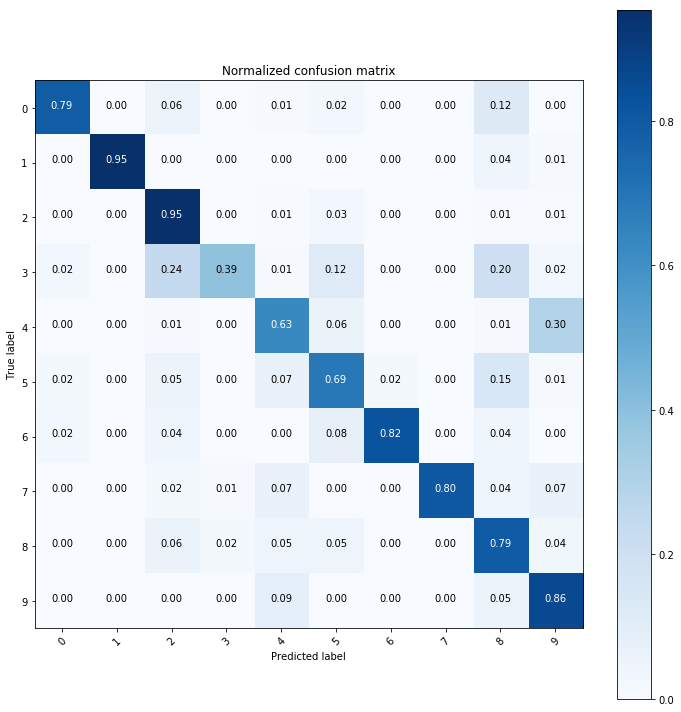


 Proportions [train, test] : [0.3, 0.7] 



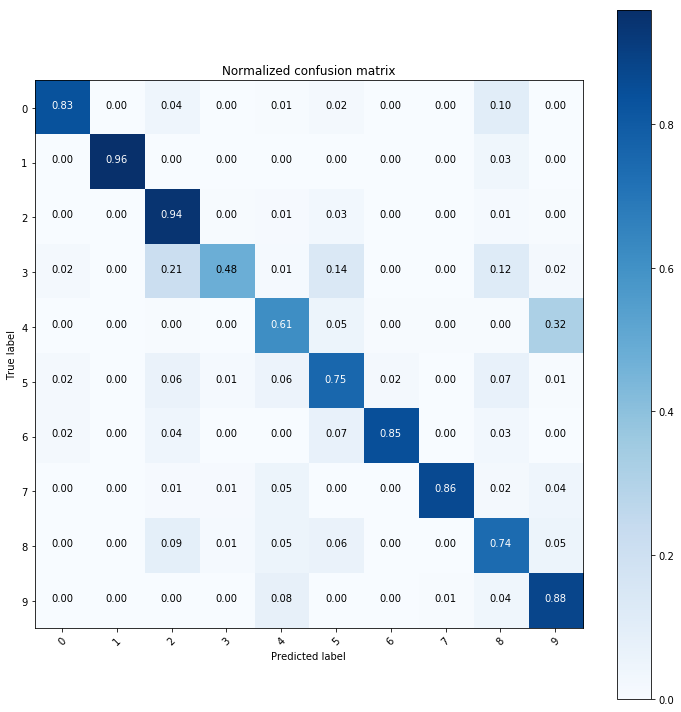


 Proportions [train, test] : [0.4, 0.6] 



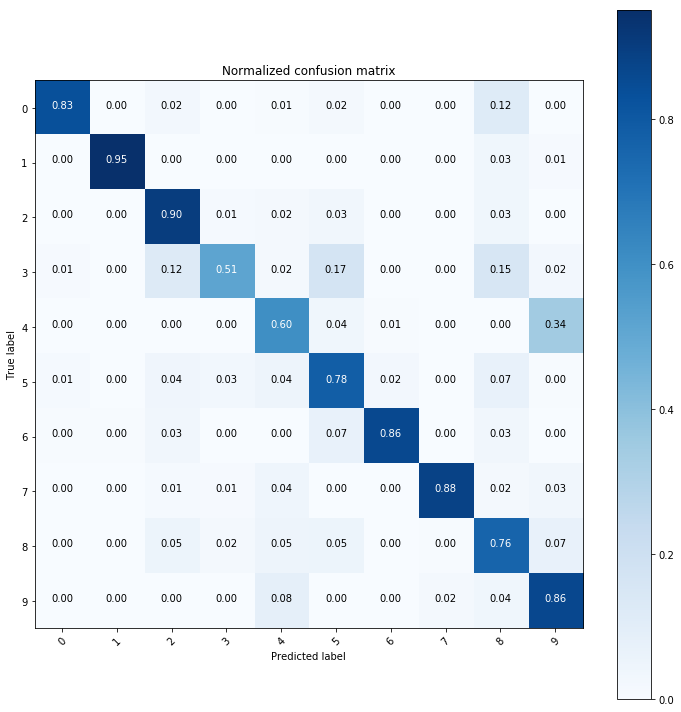


 Proportions [train, test] : [0.5, 0.5] 



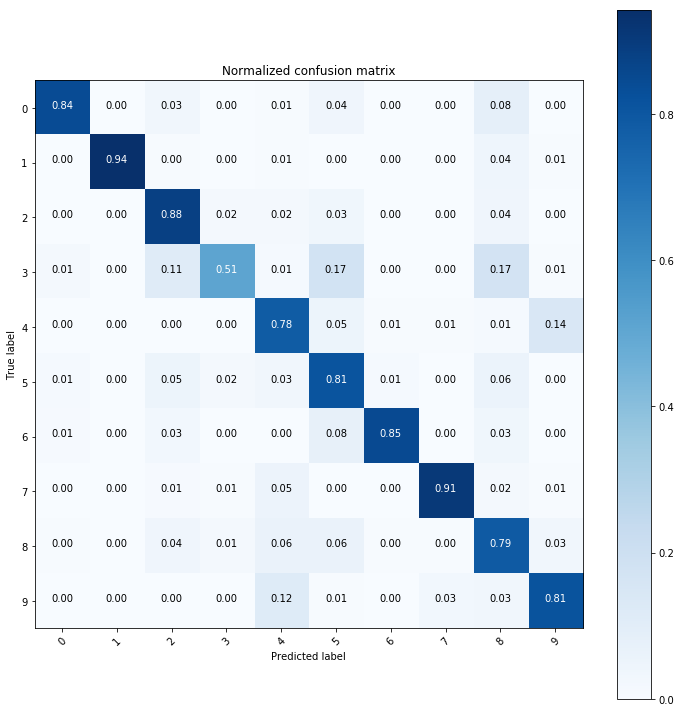


 Proportions [train, test] : [0.6, 0.4] 



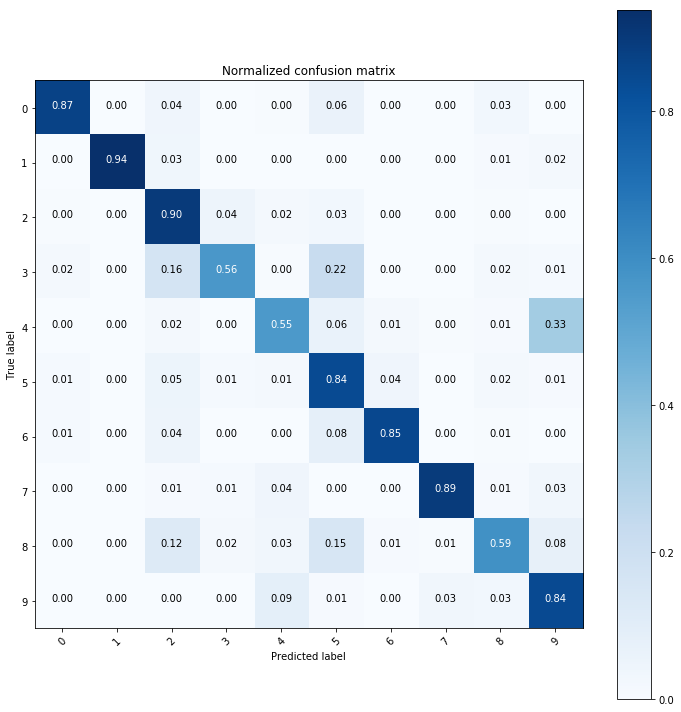


 Proportions [train, test] : [0.7, 0.3] 



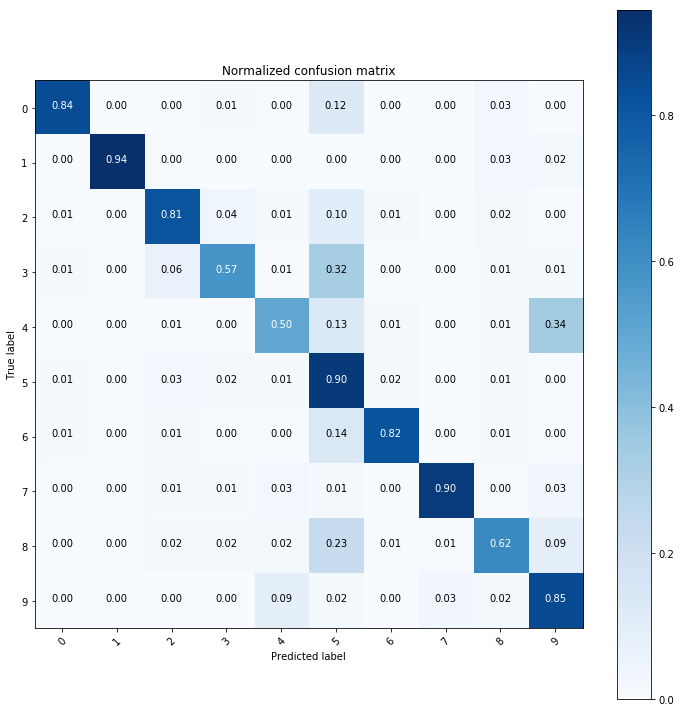


 Proportions [train, test] : [0.8, 0.2] 



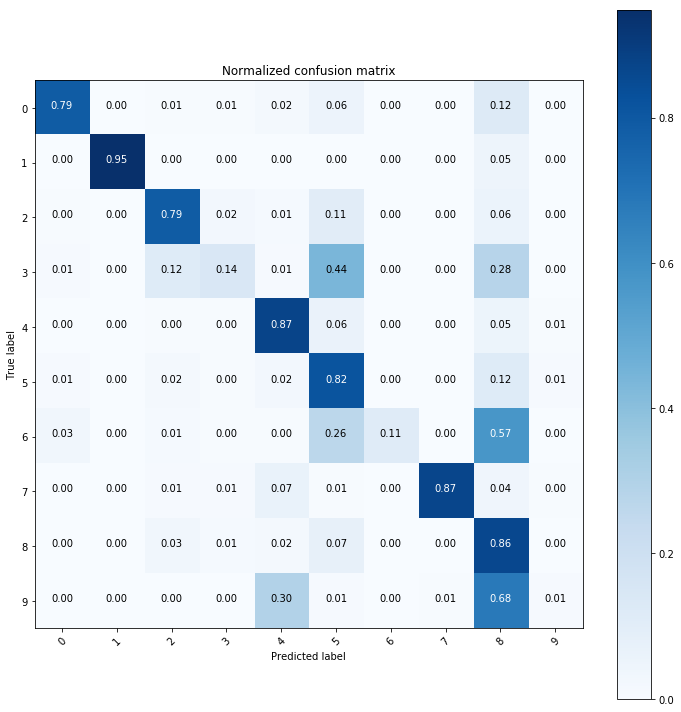


 Proportions [train, test] : [0.9, 0.1] 



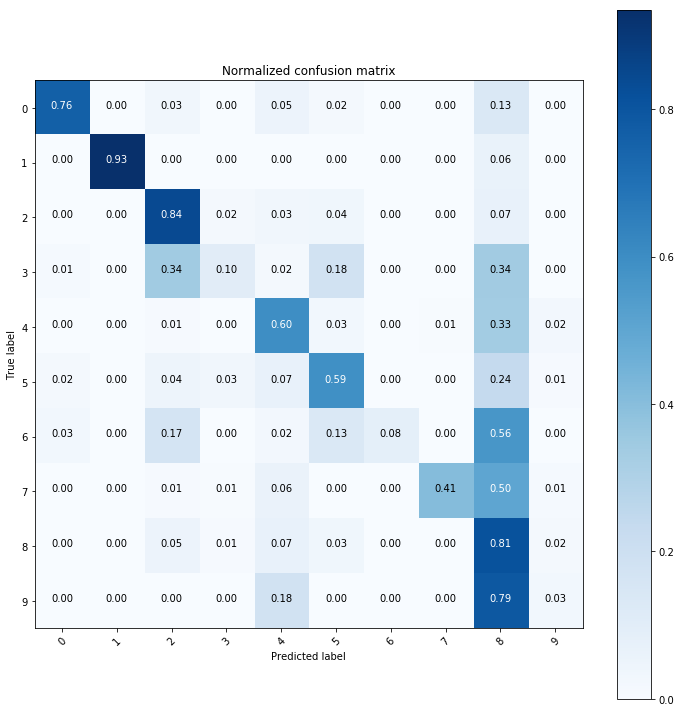

In [11]:
def question23 (data, labels):
    proportions = np.arange(0.1, 1.0, 0.1)
    
    for i in proportions :
        
        print ('\n Proportions [train, test] : [{}, {}] \n'.format(round(i,2),round(1 - i,2)))
        question223(data_train, labels_train, i, True)

question23(data_train, labels_train)

On voit que pour chaque séparation de données il y a le problème avec évaluation de la classe "3", mais avec différents tailles d'ensemble "train" on peut avoir la plus basse erreur d'évaluation des classes.

#### Q 2.4 Validation croisée

In [12]:
def cross_validation (data, labels, n=5):
    
    nb_exemples = len(labels)
    h_ex = int(nb_exemples*1.0/n)
    
    cross_ex = np.arange(0, nb_exemples, h_ex)
    
    cm_cross = np.zeros((10,10))
    
    for i in cross_ex[:-1]:
        X_test = data[i:(i+h_ex),:]
        y_test = labels[i:(i+h_ex)]
        X_train = np.delete(data, np.s_[i:(i+h_ex)], 0)
        y_train = np.delete(labels, np.s_[i:(i+h_ex)], 0)
        
        model = fit_bayes(X_train, y_train)
        y_pred = predict_bayes(X_test, model)
        cm_cross = cm_cross + confusion_matrix(y_test, y_pred)
    
    cm_cross = cm_cross/n
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm_cross, classes=class_names, normalize=True,
                              title='Normalized confusion matrix after cross validation')
    plt.show()    


Number of parts : 2



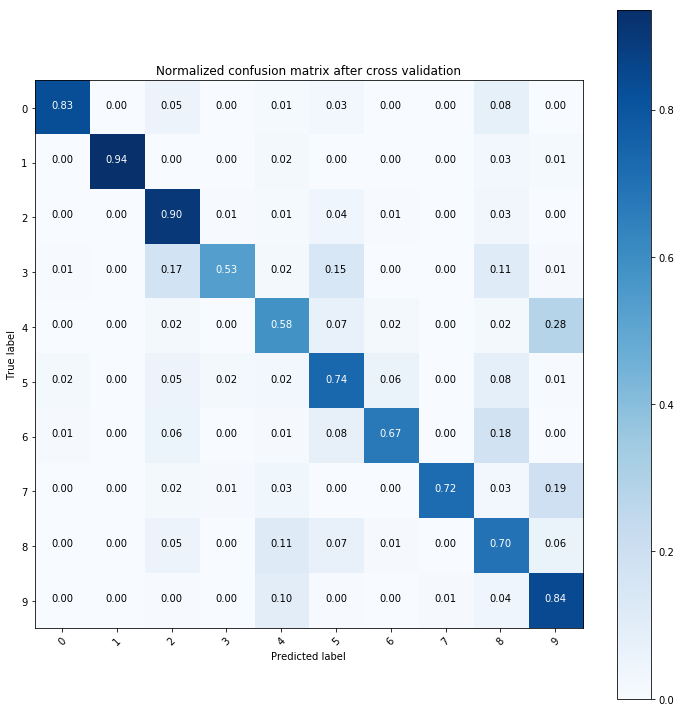


Number of parts : 3



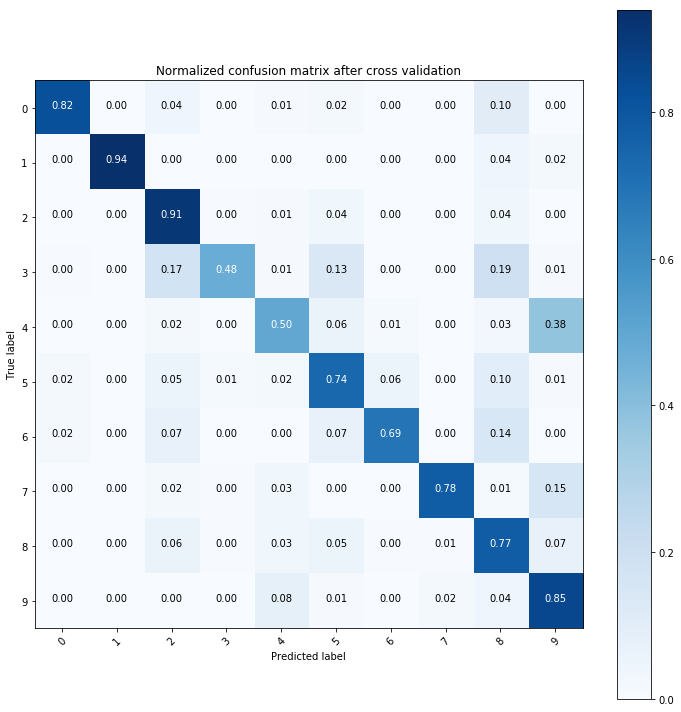


Number of parts : 4



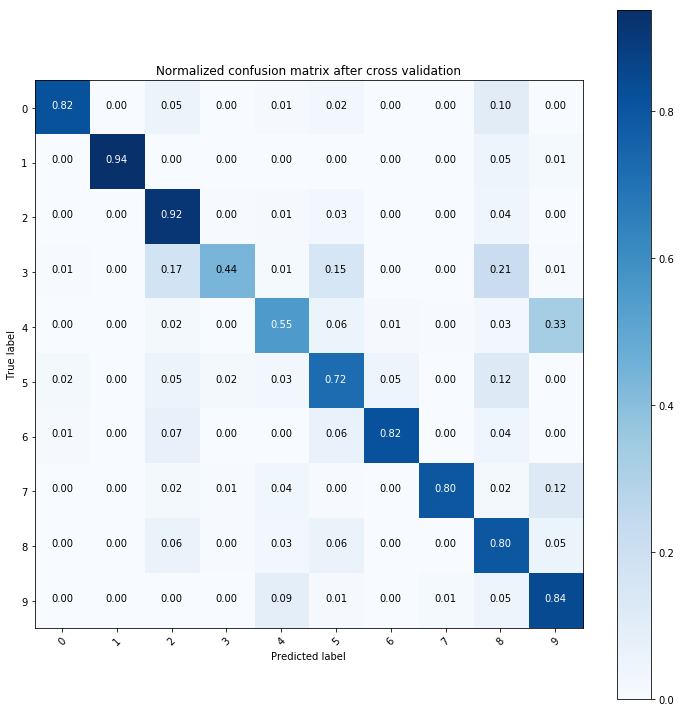


Number of parts : 5



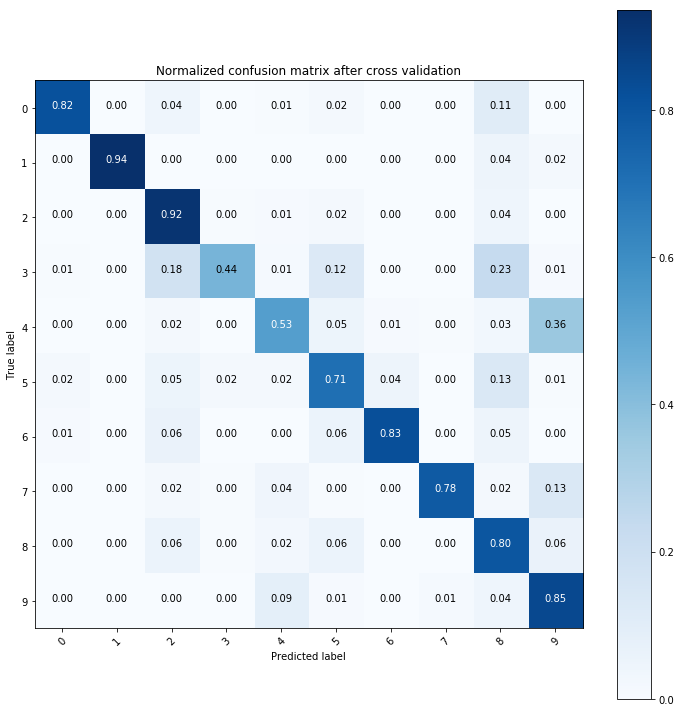


Number of parts : 6



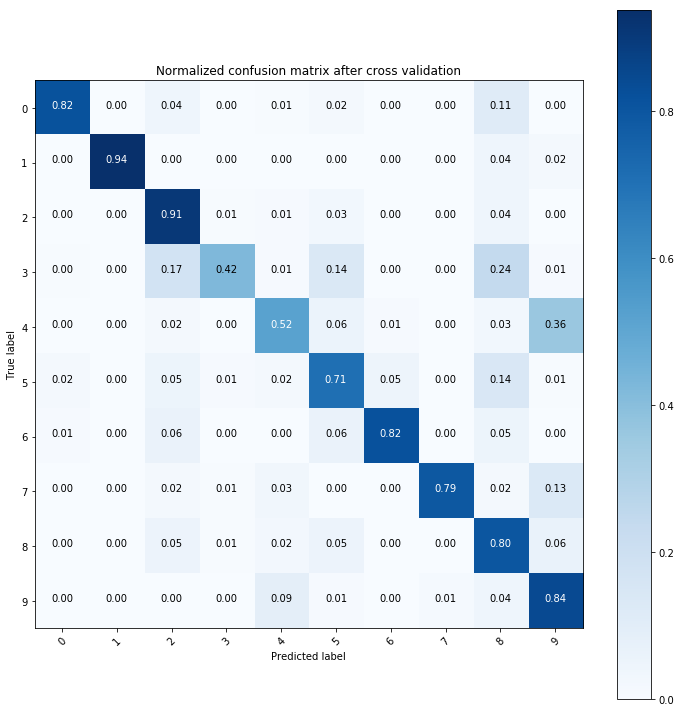


Number of parts : 7



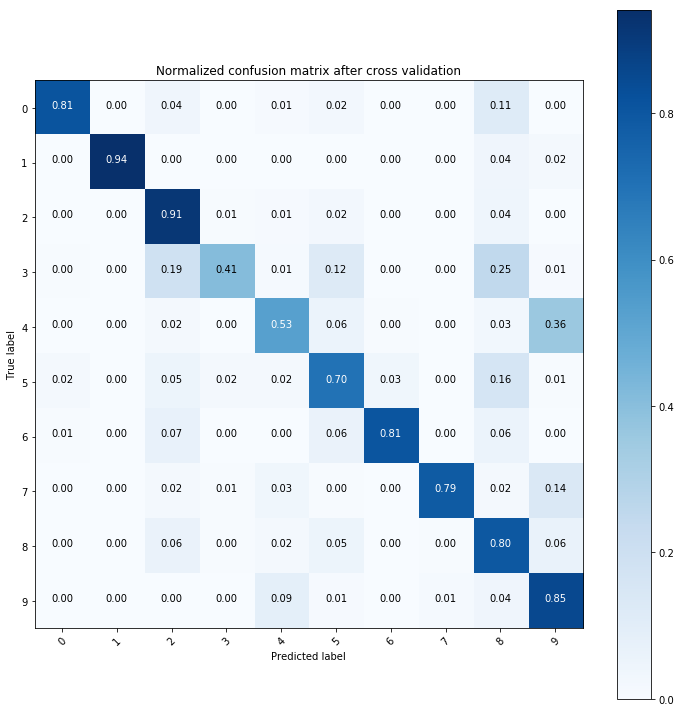


Number of parts : 8



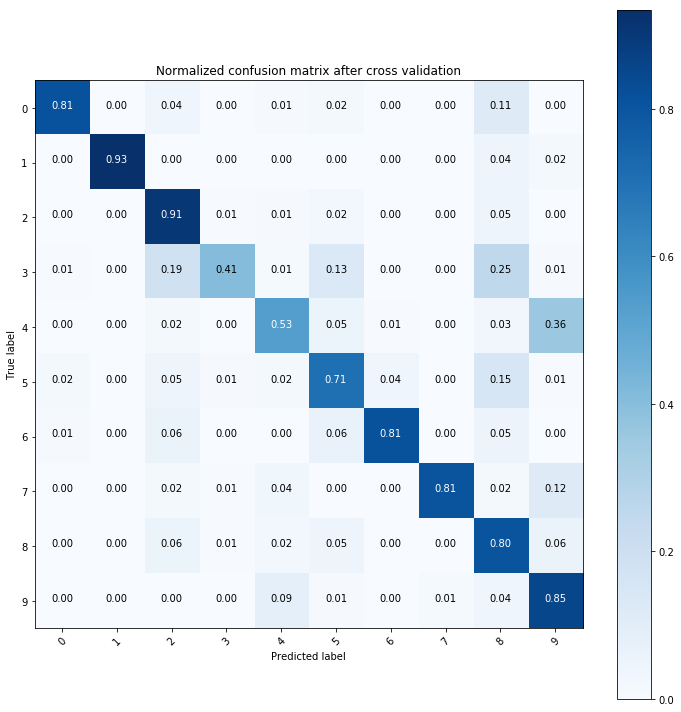


Number of parts : 9



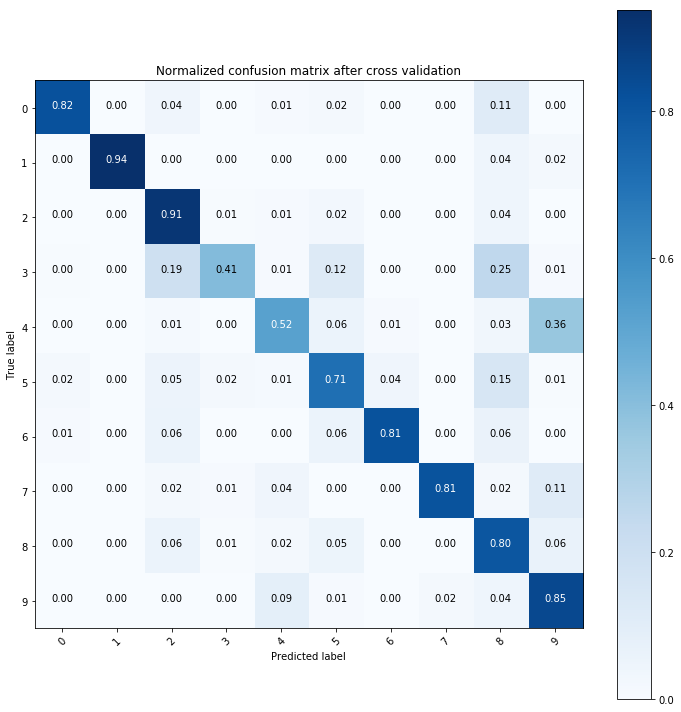

In [13]:
def question23 (data, labels):
    numbers = np.arange(2,10)
    
    for i in numbers:
        print ('\nNumber of parts : {}\n'.format(i))
        cross_validation(data, labels, i)

question23(data_train, labels_train)   

Contrairement à la méthode "held-out/hold-out set" pour validation croisée on a les résultats qui sont suffisamment stables par rapport au changement de nombre des parties. De plus, on peut voir le problème avec la classe "4" que on a vu dans la question précédente avec proportions des données [train, test] : [0.7, 0.3] .

## 3 Arbres de décision, k-nn et boosting

Dans cette partie vous allez comparer qualitativement les algorithmes suivants : arbre de décision ``sklearn.tree.DecisionTreeClassifier``, les forêts ``sklearn.ensemble.RandomForestClassifier``, le boosting ``sklearn.ensemble.AdaBoostClassifier`` et les k-nn ``sklearn.neighbors.KNeighborsClassifier``. Contrairement au classifieur bayésien, ces algorithmes disposent d’hyper-paramètres qui permettent de régler leur expressivité : profondeur pour les arbres, nombre d’arbres pour les forêts, nombre de voisins pour les k-nn et nombre d’itérations pour le boosting.

In [14]:
def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "blue","green", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),256)

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex//2))
         xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex//2))
         data=np.vstack((xpos,xneg))
         y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex//4)),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),int(nbex//4)),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),int(nbex//4))))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(int(nbex//2))))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [16]:
def plot_validation (X_train, y_train, X_test, y_test, n_param = 100):
    
    n_estimators = np.arange(1, n_param)
    
    destree_err = np.array([(1.0 - DecisionTreeClassifier(max_depth=k).fit(X_train, y_train).score(X_test, y_test)) \
                             for k in n_estimators])
    forest_err = np.array([(1.0 - RandomForestClassifier(n_estimators=k).fit(X_train, y_train).score(X_test, y_test)) \
                             for k in n_estimators])
    boost_err = np.array([(1.0 - AdaBoostClassifier(n_estimators=k).fit(X_train, y_train).score(X_test, y_test)) \
                             for k in n_estimators])
    knn_err = np.array([(1.0 - KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).score(X_test, y_test)) \
                             for k in n_estimators])    

    fig = plt.figure()
    ax1 = plt.subplot(111)
    ax1.plot(n_estimators , destree_err, label='Decision Tree')
    ax1.plot(n_estimators , forest_err, label='Random Forest')
    ax1.plot(n_estimators , boost_err, label='Boosting')
    ax1.plot(n_estimators , knn_err, label='KNN')
    ax1.set_title('Error in classification', fontsize = 16)
    ax1.legend(fontsize = 20)
    plt.xlabel('Hyper-parameter')
    plt.ylabel('Error')
    ax1.grid(color='gray', linestyle='dashed')
    
    plt.show()
    
    set_hyp_par = np.array([np.argmin(destree_err), np.argmin(forest_err), 
                            np.argmin(boost_err), np.argmin(knn_err)])
    
    print ('The best hyper paramaters : ', set_hyp_par  )
    
    return set_hyp_par

In [17]:
def question31 (i = 0, n=10):
    ### Donnees artificielles
    xgentrain,ygentrain = gen_arti(data_type=i,sigma=0.5,nbex=1000,epsilon=0.1)
    xgentest,ygentest = gen_arti(data_type=i,sigma=0.5,nbex=1000,epsilon=0.1)
    
    hyp_parameters = plot_validation (xgentrain,ygentrain, xgentest,ygentest, n)
    return hyp_parameters

In [18]:
def question32 (hyp_parameters, i = 0): 
    #hyp_parameters = [profondeur, nombre d’arbres, nombre de voisins, nombre d’itérations]
    
    ### Donnees artificielles
    xgentrain,ygentrain = gen_arti(data_type=i,sigma=0.5,nbex=1000,epsilon=0.1)
    xgentest,ygentest = gen_arti(data_type=i,sigma=0.5,nbex=1000,epsilon=0.1)
    
    
    # Arbre de décision
    classifier = DecisionTreeClassifier(max_depth=hyp_parameters[0]).fit(xgentrain,ygentrain)
    plt.figure()
    plot_frontiere(xgentrain, classifier.predict)
    plot_data(xgentrain,ygentrain)
    plt.title('Arbre de décision', fontsize = 20)
    plt.show()
    
    # Forêts
    classifier = RandomForestClassifier(n_estimators=hyp_parameters[1]).fit(xgentrain,ygentrain)
    plt.figure()
    plot_frontiere(xgentrain, classifier.predict)
    plot_data(xgentrain,ygentrain)
    plt.title('Forêts', fontsize = 20)
    plt.show()
    
    # Boosting
    classifier = AdaBoostClassifier(n_estimators=hyp_parameters[2]).fit(xgentrain,ygentrain)
    plt.figure()
    plot_frontiere(xgentrain, classifier.predict)
    plot_data(xgentrain,ygentrain)
    plt.title('Boosting', fontsize = 20)
    plt.show()
    
    # K-nn
    classifier = KNeighborsClassifier(n_neighbors=hyp_parameters[3]).fit(xgentrain,ygentrain)
    plt.figure()
    plot_frontiere(xgentrain, classifier.predict)
    plot_data(xgentrain,ygentrain)
    plt.title('KNN', fontsize = 20)
    plt.show()

### i = 0

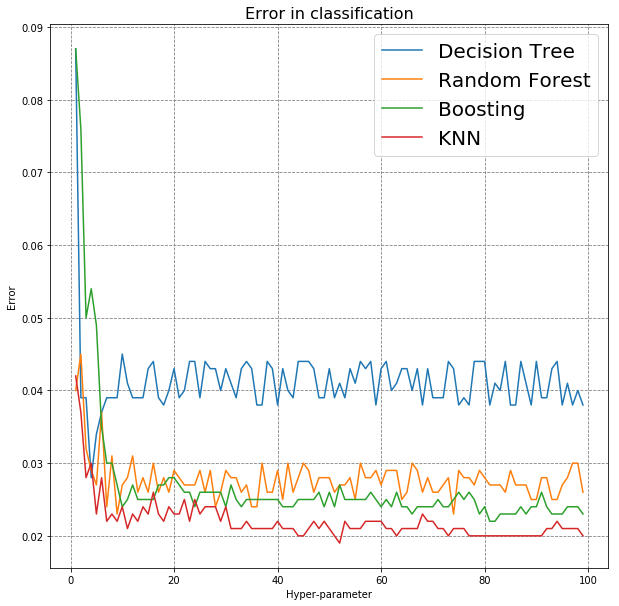

The best hyper paramaters :  [ 3  8 80 51]


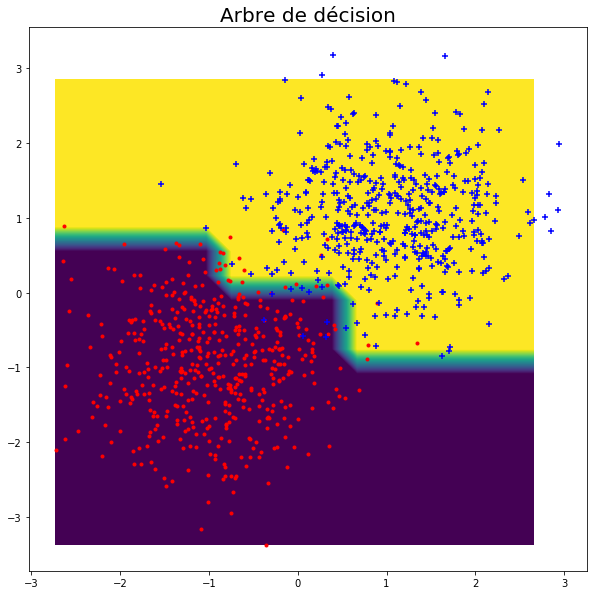

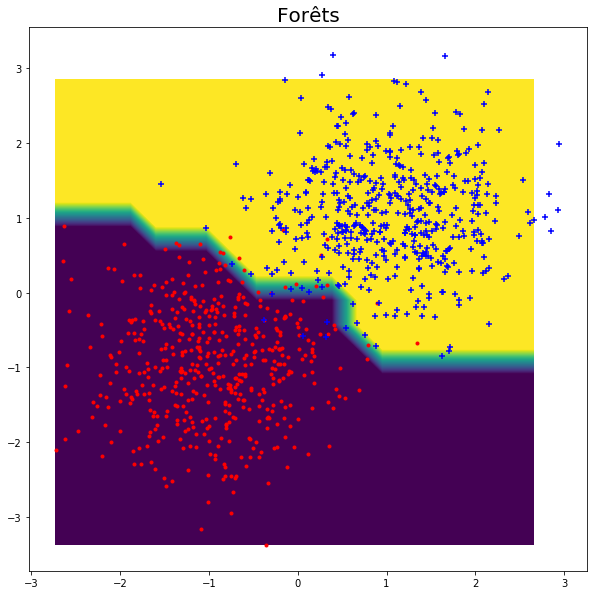

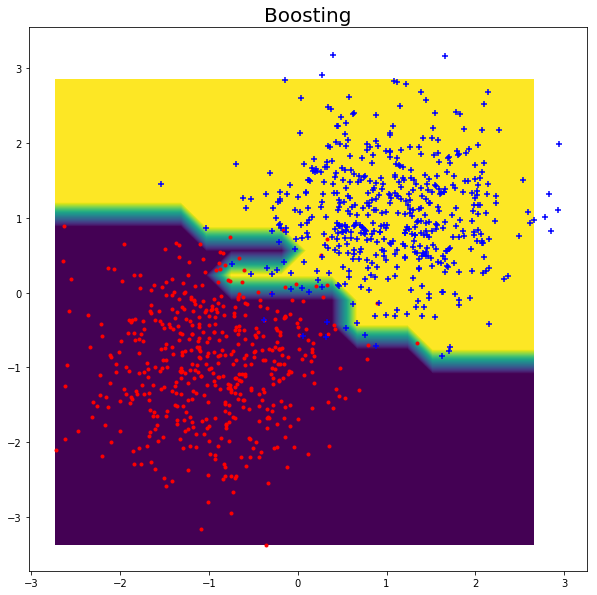

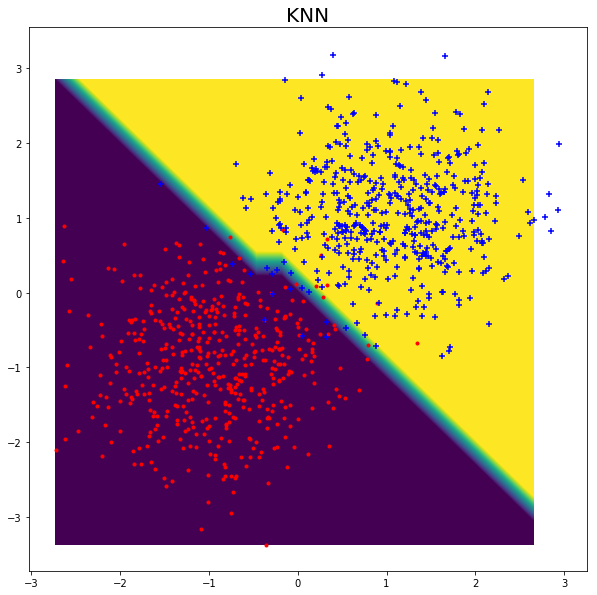

In [19]:
hyp_parameters = question31(0, n = 100)
question32(hyp_parameters, 0)

### i = 1

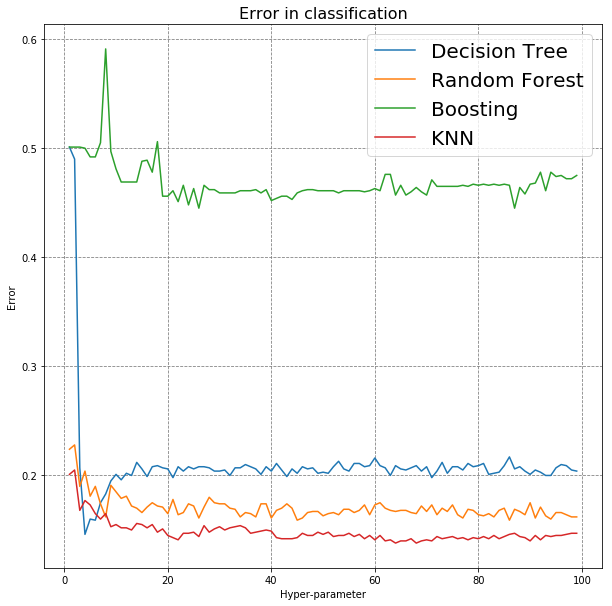

The best hyper paramaters :  [ 3 44 25 63]


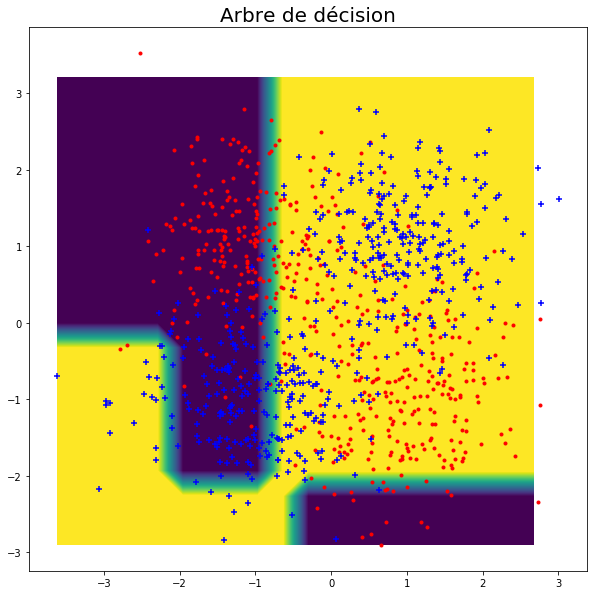

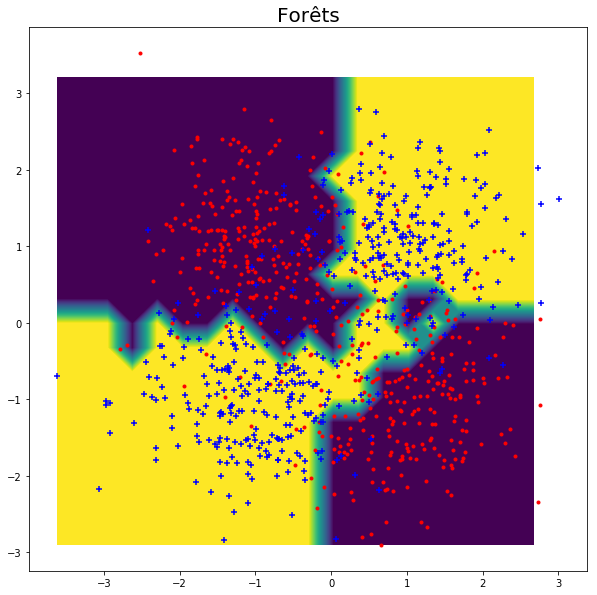

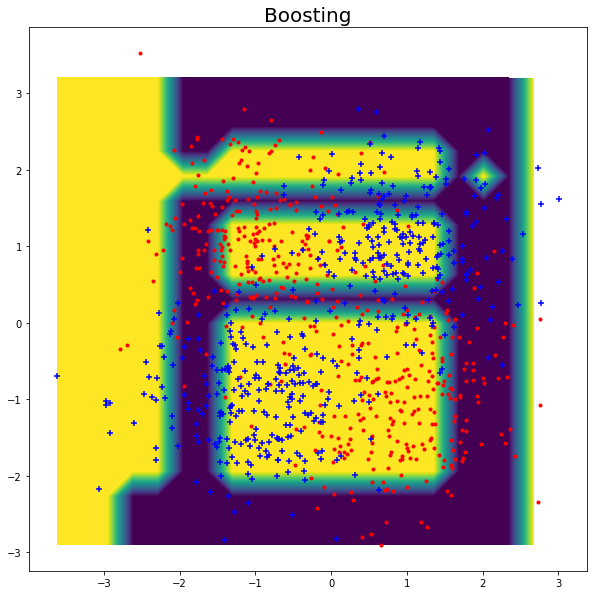

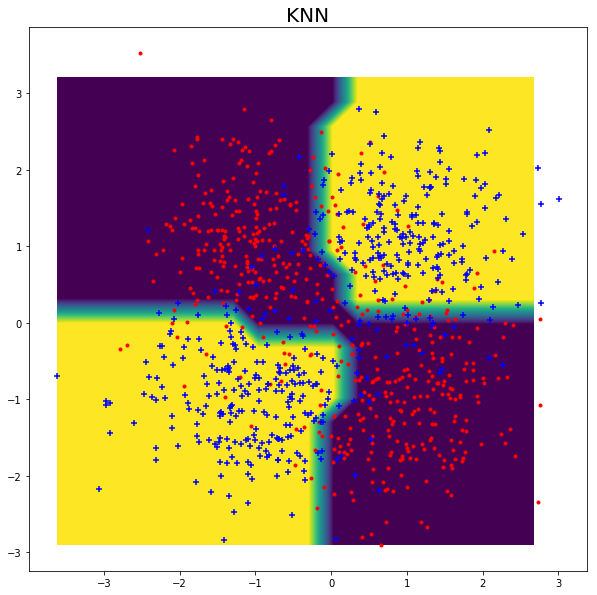

In [20]:
hyp_parameters = question31(1, n=100)
question32(hyp_parameters, 1)

### i = 2

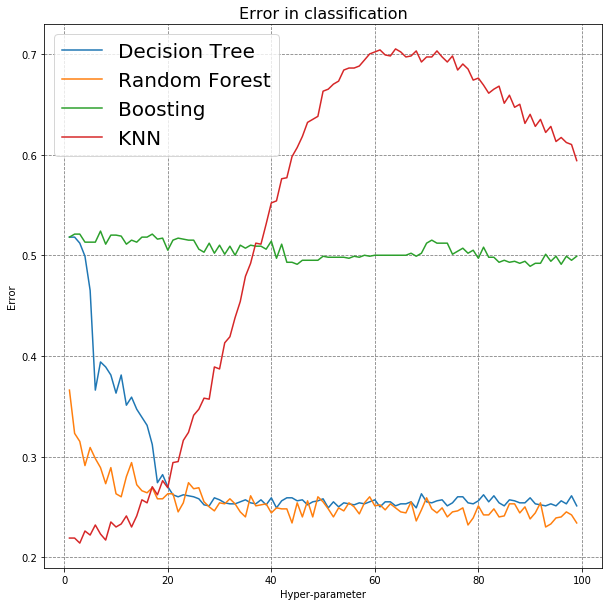

The best hyper paramaters :  [40 92 89  2]


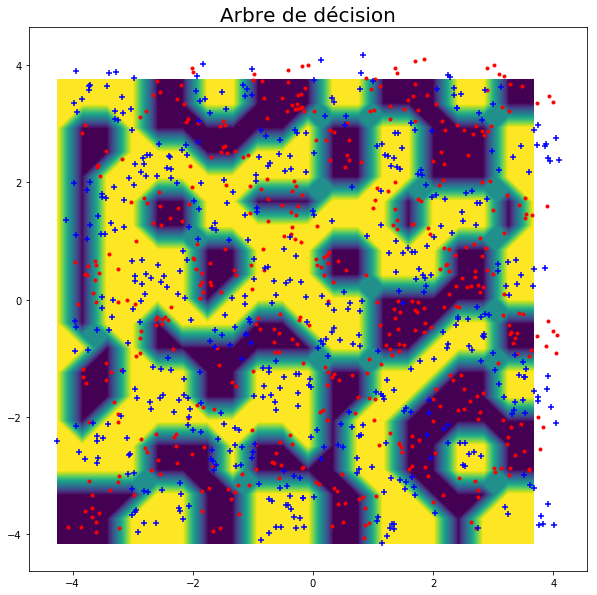

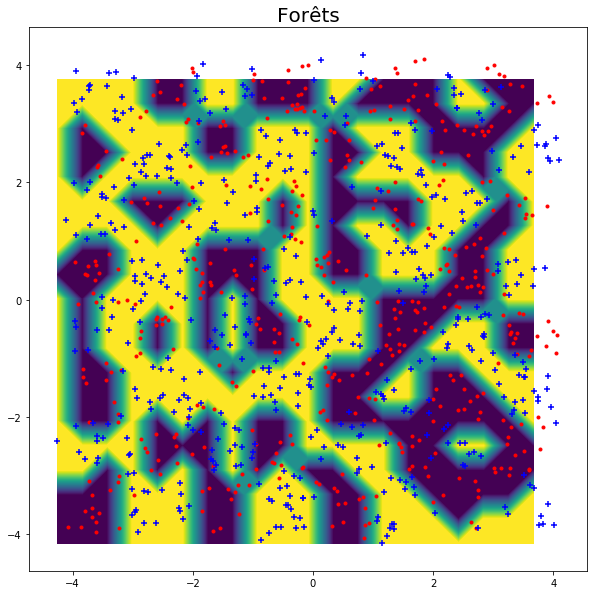

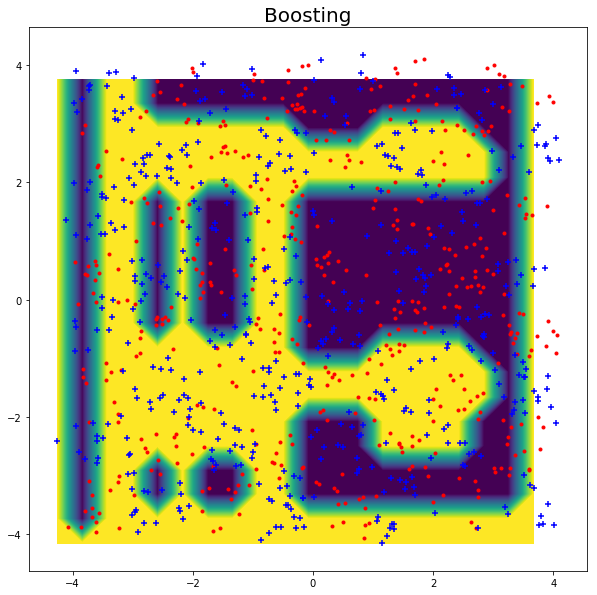

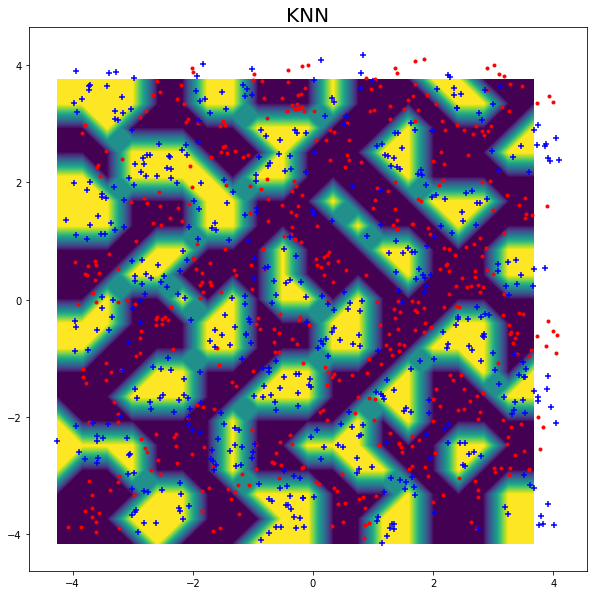

In [21]:
hyp_parameters = question31(2, n=100)
question32(hyp_parameters, 2)

On voit que avec la forte fusion de classes (comme dans les cas i = 1,2) la séparation de classes est vraiment complexe. En autre, dans ces cas l'erreur pour Boosting est à côté de 0.5 pour tout les hyper paramètres.

## 4 Mesure de perfomances et sélection de modèles

Pour les donnees IMDB, on ignore le nombre de notes et binarise la base de données imdb (donc un seuil) : toutes les notes supérieures à 6.5 seront de la classe ``1``, celles inférieures de a classe ``0``.

In [22]:
data_bin = datax
rating_bin = np.maximum(0,np.sign(rating-6.5))

Soit ``FP`` l’ensemble des faux positifs (exemples négatifs étiquetés comme positifs), ``FN`` les faux négatifs (exemples positifs étiquetés comme négatifs), ``N`` l’ensemble des négatifs, ``P`` celui des positifs, $ \alpha =\frac{|FP|}{|N|} $ le taux de faux positifs et $\beta = \frac{|FN|}{|P|} $ le taux de faux négatifs, $ prec = \frac{|TP|}{|FP|+|TP|} $ la précision et $ recall = \frac{|TP|}{|P|} $ le rappel. La courbe ROC est le tracé de la courbe $(\alpha, 1−\beta) $ et l’aire sous la cette courbe (AUC) est un indicateur des performances du classifieur.

``Une aire elevee est-elle synonyme de bonne ou de mauvaise performance ?``

### Validation croisée :

In [31]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV

In [24]:
def question421 (data, label, n=500):
    best_hyp_par = []
    
    parameters = {'max_depth': np.arange(1,n)}
    destree_m = GridSearchCV(DecisionTreeClassifier(), parameters, scoring='roc_auc', n_jobs=8, cv=5)
    destree_m.fit(data, label)
    print ('\nDecision Tree : \n')
    print ("Optimal parameters:", destree_m.best_params_)
    print ("Score:", destree_m.best_score_)
    
    best_hyp_par.append(destree_m.best_params_.get('max_depth'))
    
    parameters = {'n_estimators': np.arange(1,n)}
    forest_m = GridSearchCV(RandomForestClassifier(), parameters, scoring='roc_auc', n_jobs=8, cv=5)
    forest_m.fit(data, label)
    print ('\nRandom Forest : \n')
    print ("Optimal parameters:", forest_m.best_params_)
    print ("Score:", forest_m.best_score_)
    
    best_hyp_par.append(forest_m.best_params_.get('n_estimators'))
    
    boost_m = GridSearchCV(AdaBoostClassifier(), parameters, scoring='roc_auc', n_jobs=8, cv=5)
    boost_m.fit(data, label)
    print ('\nBoosting : \n')
    print ("Optimal parameters:", boost_m.best_params_)
    print ("Score:", boost_m.best_score_)
    
    best_hyp_par.append(boost_m.best_params_.get('n_estimators'))
    
    parameters = {'n_neighbors': np.arange(1,n)}
    knn_m = GridSearchCV(KNeighborsClassifier(), parameters, scoring='roc_auc', n_jobs=8, cv=5)
    knn_m.fit(data, label)
    print ('\nDecision Tree : \n')
    print ("Optimal parameters:", knn_m.best_params_)
    print ("Score:", knn_m.best_score_)
    
    best_hyp_par.append(knn_m.best_params_.get('n_neighbors'))
    
    return np.array(best_hyp_par)

In [25]:
%%time

print('List of optimal parameters by cross-validation for every classification methodes : \n')
best_hyp_par_cv = question421(data_bin, rating_bin, 20)

List of optimal parameters by cross-validation for every classification methodes : 


Decision Tree : 

Optimal parameters: {'max_depth': 6}
Score: 0.7849625818808931

Random Forest : 

Optimal parameters: {'n_estimators': 16}
Score: 0.7975053075847983

Boosting : 

Optimal parameters: {'n_estimators': 19}
Score: 0.8125101841989603

Decision Tree : 

Optimal parameters: {'n_neighbors': 18}
Score: 0.7360298975126114
Wall time: 11.6 s


In [26]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from sklearn.dummy import DummyClassifier

In [27]:
def metrics_curves (X_train, X_test, y_train, y_test, hyp_par) :
    
    # constant model
    const_mod = DummyClassifier(strategy='constant', random_state=17, constant=1)
    const_mod_prob = const_mod.fit(X_train, y_train).predict_proba(X_test)

    for_const_mod={}
    for_const_mod['fpr'], for_const_mod['tpr'], for_const_mod['thresholds'] = metrics.roc_curve(y_test, [x[1] for x in const_mod_prob])
    for_const_mod['precr'], for_const_mod['recr'], for_const_mod['thresholds'] = metrics.precision_recall_curve(y_test, [x[1] for x in const_mod_prob])

    # decision tree
    tree = DecisionTreeClassifier(max_depth=hyp_par[0])
    tree_pred_prob = tree.fit(X_train, y_train).predict_proba(X_test)

    for_tree={}
    for_tree['fpr'], for_tree['tpr'], for_tree['thresholds'] = metrics.roc_curve(y_test, [x[1] for x in tree_pred_prob])
    for_tree['precr'], for_tree['recr'], for_tree['thresholds'] = metrics.precision_recall_curve(y_test, [x[1] for x in tree_pred_prob])

    # random forest
    forest = RandomForestClassifier(n_estimators=hyp_par[1])
    forest_pred_prob = forest.fit(X_train, y_train).predict_proba(X_test)

    for_forest={}
    for_forest['fpr'], for_forest['tpr'], for_forest['thresholds'] = metrics.roc_curve(y_test, [x[1] for x in forest_pred_prob])
    for_forest['precr'], for_forest['recr'], for_forest['thresholds'] = metrics.precision_recall_curve(y_test, [x[1] for x in forest_pred_prob])

    # boosting
    boost = AdaBoostClassifier(n_estimators=hyp_par[2])
    boost_pred_prob = boost.fit(X_train, y_train).predict_proba(X_test)

    for_boost={}
    for_boost['fpr'], for_boost['tpr'], for_boost['thresholds'] = metrics.roc_curve(y_test, [x[1] for x in boost_pred_prob])
    for_boost['precr'], for_boost['recr'], for_boost['thresholds'] = metrics.precision_recall_curve(y_test, [x[1] for x in boost_pred_prob])

    # KNN
    knn_pr = KNeighborsClassifier(n_neighbors=hyp_par[3])
    knn_prob = knn_pr.fit(X_train, y_train).predict_proba(X_test)

    for_knn={}
    for_knn['fpr'], for_knn['tpr'], for_knn['thresholds'] = metrics.roc_curve(y_test, [x[1] for x in knn_prob])
    for_knn['precr'], for_knn['recr'], for_knn['thresholds'] = metrics.precision_recall_curve(y_test, [x[1] for x in knn_prob])

    return [const_mod_prob, tree_pred_prob, forest_pred_prob, boost_pred_prob,
            knn_prob, for_const_mod, for_tree, for_forest, for_boost, for_knn]
    
def plot_ROC (X_train, X_test, y_train, y_test, hyp_par) :
    
    ###########################################
    #       Metrics for roc - curve           #
    ###########################################
    const_mod_prob, tree_pred_prob, forest_pred_prob, \
    boost_pred_prob, knn_prob, for_const_mod, for_tree, \
    for_forest, for_boost, for_knn = metrics_curves (X_train, X_test, y_train, y_test, hyp_par)
    
    ###########################################
    #              ROC - curves               #
    ###########################################

    plt.figure()
    lw = 1.5
    
    # constant model
    plt.plot(for_const_mod['fpr'], for_const_mod['tpr'], color='darkorange',
             lw=1.5, linestyle='--', label='Constant model (area = %0.2f)' % roc_auc_score(np.array(y_test), np.array([x[1] for x in const_mod_prob])))
    # decision tree
    plt.plot(for_tree['fpr'], for_tree['tpr'], color='red',
             lw=1.5, label='Decision tree (area = %0.2f)' % roc_auc_score(np.array(y_test), np.array([x[1] for x in tree_pred_prob])))
    # random forest
    plt.plot(for_forest['fpr'], for_forest['tpr'], color='blue',
             lw=1.5, label='Random forest (area = %0.2f)' % roc_auc_score(np.array(y_test), np.array([x[1] for x in forest_pred_prob])))
    # boosting
    plt.plot(for_boost['fpr'], for_boost['tpr'], color='orange',
             lw=1.5, label='Boosting (area = %0.2f)' % roc_auc_score(np.array(y_test), np.array([x[1] for x in boost_pred_prob])))
    # KNN
    plt.plot(for_knn['fpr'], for_knn['tpr'], color='green',
             lw=1.5, label='KNN (area = %0.2f)' % roc_auc_score(np.array(y_test), np.array([x[1] for x in knn_prob])))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

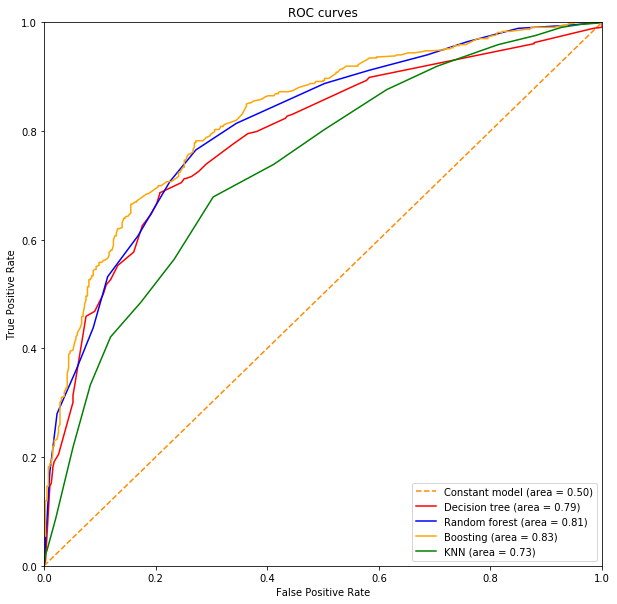

In [28]:
def question421_ROC (data, labels, best_hyp_par, proportion = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=proportion, random_state=19)
    plot_ROC(X_train, X_test, y_train, y_test, best_hyp_par)  
    
question421_ROC(data_bin, rating_bin, best_hyp_par_cv)

Puisque on a ajouté sur le graphique le ROC-curve pour modèle qui donne toujours une classe on peut voir clairement que les meilleur algorithmes de classification (avec ces paramètres optimaux) sont "Boosting" et "Random forest".

In [29]:
def plot_F1 (X_train, X_test, y_train, y_test, hyp_par) :
    
    ###########################################
    #       Metrics for F1 - curve           #
    ###########################################
    const_mod_prob, tree_pred_prob, forest_pred_prob, \
    boost_pred_prob, knn_prob, for_const_mod, for_tree, \
    for_forest, for_boost, for_knn = metrics_curves (X_train, X_test, y_train, y_test, hyp_par)
    
    ###########################################
    #              F1 - curves               #
    ###########################################
    
    def f1_metrics (precision, recall):
        F1 = 2 * (precision * recall) / (precision + recall)
        return F1

    plt.figure()
    lw = 1.5
    
    # constant model
    plt.plot(for_const_mod['recr'], f1_metrics(for_const_mod['precr'], for_const_mod['recr']), 
             color='darkorange', lw=1.5, linestyle='--', label='Constant model') 
    
    # decision tree
    plt.plot(for_tree['recr'], f1_metrics(for_tree['precr'],for_tree['recr']),
             color='red', lw=1.5, label='Decision tree')
    
    # random forest
    plt.plot(for_forest['recr'], f1_metrics(for_forest['precr'], for_forest['recr']), 
             color='blue', lw=1.5, label='Random forest')
    # boosting
    plt.plot(for_boost['recr'], f1_metrics(for_boost['precr'],for_boost['recr']),
             color='orange', lw=1.5, label='Boosting')
    # KNN
    plt.plot(for_knn['recr'], f1_metrics(for_knn['precr'], for_knn['recr']), 
             color='green', lw=1.5, label='KNN')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall Rate')
    plt.ylabel('F1 score')
    plt.title('F1/Recall curves')
    plt.legend(loc="lower left")
    plt.show()

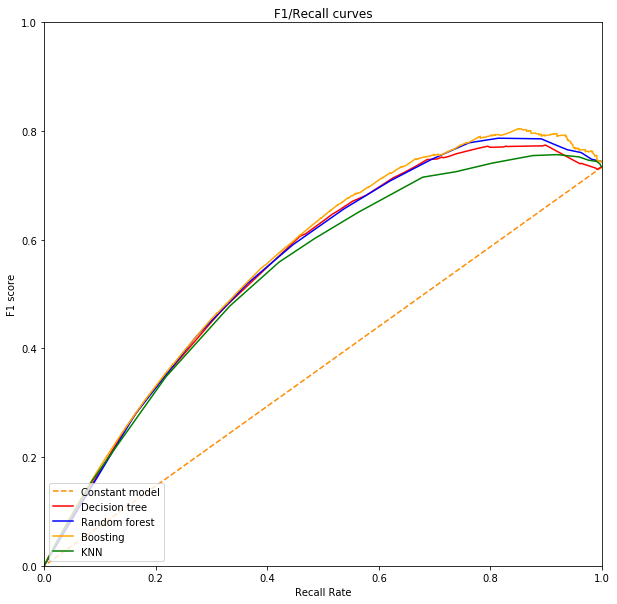

In [30]:
def question422_F1 (data, labels, best_hyp_par, proportion = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=proportion, random_state=19)
    plot_F1(X_train, X_test, y_train, y_test, best_hyp_par)  
    
question422_F1(data_bin, rating_bin, best_hyp_par_cv)